In [1]:
from torch import utils
from torch.utils import data
import utils

import gzip
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from Bio import SeqIO
import torch

import glob
import torch
from torch.utils import data
import utils
import re
import random
# Todo: replace pandas with pure numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pad_size=1000

# Read fastq
# Sample file
# Pass sample to encoder
    # Get encodings
    # Get loss
    # Backprop and update
# Pass gene counts (?) to cell encoding model
    # get encodings
    # get loss
    # backprop and update
# ???
# Profit

In [2]:
def gpu_status():
    gpu_present = [torch.cuda.device(i) for i in range(torch.cuda.device_count())] != []
    print("GPU Detected?: " + str(gpu_present))
    if gpu_present:
        torch.set_default_device('cuda')
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    return device


def get_seqios(file):
    seqs = {}
    if file[-2::] == "gz":
        with gzip.open(file, 'rt') as fastq:
            for index, record in enumerate(SeqIO.parse(fastq, 'fastq')):
                seqs.update({record.id:str(record.seq)})
            return seqs

    else:
        with open(file, "r") as fastq:
            for index, record in enumerate(SeqIO.parse(fastq, 'fastq')):
                seqs.update({record.id:str(record.seq)})
            return seqs


def parse_reads(record, pad_size):
    enc = OneHotEncoder()
    enc.fit(np.array(["A", "T", "C", "G", "N"]).reshape(-1, 1))
    x_in = np.array(list(record))
    arr = enc.fit_transform(x_in.reshape(-1, 1)).toarray()
    delta = len(arr) - pad_size

    if delta > 0:
        # random crop
        shift = np.random.randint(0, delta)
        x_out = arr[shift:shift + pad_size]

    else:
        arr.resize((pad_size, 4), refcheck=False)
        x_out = arr

    return x_out


class mRNA_Encoder:

    def __init__(self, model, pad_size=1000, checkpoint=None):
        self.pad_size = pad_size
        self.model = model
        self.device = gpu_status()
        if checkpoint is not None:
            state_dict = torch.load(checkpoint)
            self.model.load_state_dict(state_dict=state_dict)

    class Dataset(data.Dataset):
        def __init__(self, training_path, pad_size):
            self.data = glob.glob(training_path)
            self.PAD_SIZE = pad_size

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()

            path = self.data[idx]
            out = parse_reads(path, self.PAD_SIZE)
            out = out.reshape(self.PAD_SIZE, 4)
            out = torch.tensor(out).to(torch.float)
            return out

    def train_encoder(self, training_path, epochs=1, pad_size=1000, batch_size=1, lr=0.1, decay=1e-9):
        dataset = self.Dataset(training_path, pad_size)
        epochs = epochs
        batch_size = batch_size
        lr = lr
        decay = decay
        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=decay)
        dataloader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=0,
                                                 generator=torch.Generator(device='cuda'))

        losses = []
        for epoch in range(epochs):
            print("epoch" + str(epoch))
            batch = next(iter(dataloader))
            for batch_index, doc in enumerate(batch):
                recon = self.model(doc)
                # Loss function
                loss = loss_function(recon, doc)
                if batch_index % 10 == 0:
                    print("Batch: " + str(batch_index))
                    print("loss" + str(loss))

                # Gradients are set to zero,
                # Gradient is computed and stored.
                # .step() performs parameter update.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss)

        return self.model, losses

    def seq_to_embedding(self, seq):
        seq = parse_reads(seq, pad_size=self.pad_size)
        seq = torch.tensor(seq).to(torch.float)
        embedding = self.model.encoder(seq).cpu().detach().numpy().flatten()
        return embedding

    def embed_file(self, file):
        seqs = get_seqios(file)
        df = pd.DataFrame.from_dict(seqs, orient='index')
        with torch.no_grad():
            sample = df.apply(self.seq_to_embedding, axis=1, result_type='expand')
        return sample

    def embed_fastqs(self, in_filepath="", out_filepath=""):
        fastqs = glob.glob(in_filepath + "*.fastq.gz")
        for n, file in enumerate(fastqs):
            subbed = re.sub("fastq", "encoded", file)
            subbed = re.sub(".fastq.gz", ".csv", subbed)
            encoded = self.embed_file(file)
            encoded.to_csv(out_filepath + subbed)
            print("Finished: " + str(n) + " Of " + str(len(fastqs)))

In [3]:
class AE(torch.nn.Module):
    def __init__(self, pad_size):
        super().__init__()
        self.PAD_SIZE = pad_size

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(self.PAD_SIZE, 800, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(800, 400, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(400, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 16, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 16, 1)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Conv1d(16, 16, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 400, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(400, 800, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(800, self.PAD_SIZE, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class mRNA_Encoder:

    def __init__(self, model, pad_size=1000, checkpoint=None):
        self.pad_size = pad_size
        self.model = model
        self.device = utils.gpu_status()
        if checkpoint is not None:
            state_dict = torch.load(checkpoint)
            self.model.load_state_dict(state_dict=state_dict)

    class Dataset(data.Dataset):
        def __init__(self, training_path, pad_size):
            self.data = glob.glob(training_path)
            self.PAD_SIZE = pad_size

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()

            path = self.data[idx]
            out = utils.parse_reads(path, self.PAD_SIZE)
            out = out.reshape(self.PAD_SIZE, 4)
            out = torch.tensor(out).to(torch.float)
            return out

    def train_encoder(self, training_path, epochs=1, pad_size=1000, batch_size=1, lr=0.1, decay=1e-9):
        dataset = self.Dataset(training_path, pad_size)
        epochs = epochs
        batch_size = batch_size
        lr = lr
        decay = decay
        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=decay)
        dataloader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=0,
                                                 generator=torch.Generator(device='cuda'))

        losses = []
        for epoch in range(epochs):
            print("epoch" + str(epoch))
            batch = next(iter(dataloader))
            for batch_index, doc in enumerate(batch):
                recon = self.model(doc)
                # Loss function
                loss = loss_function(recon, doc)
                if batch_index % 10 == 0:
                    print("Batch: " + str(batch_index))
                    print("loss" + str(loss))

                # Gradients are set to zero,
                # Gradient is computed and stored.
                # .step() performs parameter update.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss)

        return self.model, losses

    def seq_to_embedding(self, seq):
        seq = utils.parse_reads(seq, pad_size=self.pad_size)
        seq = torch.tensor(seq).to(torch.float)
        embedding = self.model.encoder(seq).cpu().detach().numpy().flatten()
        return embedding

    def embed_file(self, file):
        # TODO: What if I don't want to embed the whole file?
        seqs = utils.get_seqios(file)
        df = pd.DataFrame.from_dict(seqs, orient='index')
        with torch.no_grad():
            sample = df.apply(self.seq_to_embedding, axis=1, result_type='expand')
        return sample

    def fastqs_to_csv(self, in_filepath="", out_filepath=""):
        fastqs = glob.glob(in_filepath + "*.fastq")
        for n, file in enumerate(fastqs):
            subbed = re.sub("fastq", "encoded", file)
            subbed = re.sub(".fastq", ".csv", subbed)
            encoded = self.embed_file(file)
            return encoded
        
#This all works, but only for pre-tokenized datasets stored in csv format. Sorry.

def get_file(filepath):
    df = pd.read_csv(filepath, index_col=0)
    names = list(df.index)
    for n, m in enumerate(names):
        names[n] = str.split(m, ":")
    metadf = pd.DataFrame(names)
    df["cell"]=(metadf[4].to_numpy())
    return df

def get_cell(df, cell, size, resample=True):
    size = int(size)
    sample = df[df["cell"]==cell].drop(columns='cell')
    replace = False==(sample.shape[0]>size)
    if resample:
        sample = sample.sample(size, replace=replace)
    else:
        if not replace:
            sample = sample.sample(size)
        if replace:
            pad = np.zeros((int(size), 64))
            pad[:sample.shape[0],:sample.shape[1]]=sample
            sample = pad
    return np.array(sample).flatten()



In [4]:
model = AE(pad_size=pad_size)
model.cuda()
encoder = mRNA_Encoder(model=model, checkpoint="C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\\RNA_Autoencoder.state_dict", pad_size=pad_size)

GPU Detected?: True
Using cuda device


In [138]:
def get_dataset(filepath, size=1e4, limit=None):
    # Filepath uses glob. example useage: ./*, ../data/*.fastq or home/data/*/*.fastq.gz
    size=int(size)
    samples = []
    names = []
    chunks = glob.glob(filepath)
    if limit is not None:
        chunks = chunks[0:(min(limit, len(chunks)))]
    for encoded in chunks:
        df = get_file(encoded)
        cell_list = df["cell"].unique()
        for cell in cell_list:
            samples.append(get_cell(df, cell, size=size, resample=True))
            name = str.split(encoded, "\\")[-1]+":"+cell
            names.append(name)

    return dict(zip(names,samples))



def sample_file(filepath, records, record_size, return_raw=False):
    
    file_list = glob.glob(filepath)
    keys = []
    raw = []
    reads_out=[]
    perfile = records/len(file_list)
    for filename in glob.glob(filepath):
        if filename.endswith(".gz"):
            filepath = filename.removesuffix(filename.split("\\")[-1])
            outname = filepath+"tmp.fastq"
            with gzip.open(filename) as file:
                with open(outname, "wb") as outfile:
                    shutil.copyfileobj(file, outfile)
            filename = filepath+"tmp.fastq"

        indexed = SeqIO.index(filename, 'fastq')
        keys+=(list(indexed.keys()))
        sample = random.sample(keys, (records*record_size))

        for s in sample:
            raw.append(str(indexed.get(s).seq))
        
        reads=[]
        # Tokenize all reads
        for n, read in enumerate(raw):
            reads.append(encoder.seq_to_embedding(read))
            
    if return_raw:
        return keys, raw, reads_out
    else:
        return reads_out

In [137]:
sample_file()

{'A': 1, 'b': 2, 'c': 3}

In [ ]:
#worms = "C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\Data\\fastq\\*.gz"
#kidney68k = "\\\\wsl.localhost\\Debian\\home\\grant\\NNRNA\\fastqs\\*\\*.gz"
#tub_cells = "\\\\wsl.localhost\\Debian\\home\\grant\\fasterq\\*.fastq"

worms = "C:\\Users\\gbwie\\Documents\\School\\BioInfo\\TermPaper\Data\\fastq\\*.gz"
kidney68k = "\\\\wsl.localhost\\Debian\\home\\grant\\NNRNA\\fastqs\\*\\*.gz"
tub_cells = "\\\\wsl.localhost\\Debian\\home\\grant\\fasterq\\*.fastq"

#TODO: Can this be integrated with sample_file to get fresh encodings?
human_samples = get_dataset('\\\\wsl.localhost\\Debian\\home\\grant\\NNRNA\\encoded\\*\\*', size=1e4, limit=10000)


In [118]:
worm_samples = sample_file(glob.glob(worms)[0:5], records=10, record_size=10000, return_raw=True)
tubular_samples = sample_file(glob.glob(tub_cells)[0:5], records=10, record_size=10000, return_raw=True)
pbmc_samples = sample_file(glob.glob(kidney68k)[0])

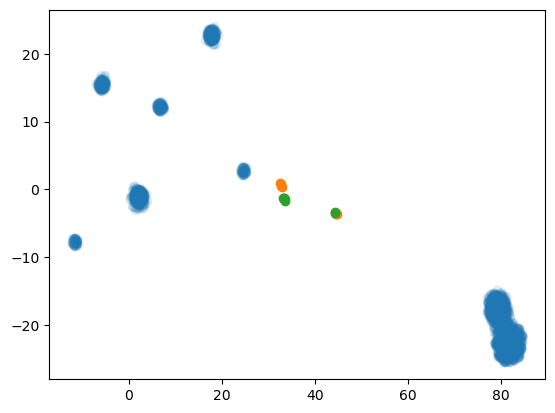

In [121]:
import umap
fit = umap.UMAP(
    n_neighbors=10,
    min_dist=3,
    n_components=2,
    metric='euclidean'
)

cell_map = fit.fit_transform(np.array(list(human_samples.values())))
worm_map = fit.transform(worm_samples[1])
tub_map = fit.transform(tubular_samples[1])
plt.scatter(cell_map[:,0], cell_map[:,1], alpha=0.1)
plt.scatter(worm_map[:,0], worm_map[:,1])
plt.scatter(tub_map[:,0], tub_map[:,1])

# Feature extraction

In [141]:
df = pd.DataFrame.from_dict(human_samples, orient='index')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gbwie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\gbwie\AppData\Local\Temp\ipykernel_18956\722562754.py", line 1, in <module>
    pd.DataFrame.from_dict(human_samples, orient='index')
  File "C:\Users\gbwie\anaconda3\lib\site-packages\pandas\core\frame.py", line 1677, in from_dict
    return cls(data, index=index, columns=columns, dtype=dtype)
  File "C:\Users\gbwie\anaconda3\lib\site-packages\pandas\core\frame.py", line 721, in __init__
    arrays, columns, index = nested_data_to_arrays(
  File "C:\Users\gbwie\anaconda3\lib\site-packages\pandas\core\internals\construction.py", line 519, in nested_data_to_arrays
    arrays, columns = to_arrays(data, columns, dtype=dtype)
  File "C:\Users\gbwie\anaconda3\lib\site-packages\pandas\core\internals\construction.py", line 880, in to_arrays
    data = [tuple(x) for x in data]
  Fil

TypeError: object of type 'NoneType' has no len()

In [116]:
df['u1']=cell_map[:,0]
df["u2"]=cell_map[:,1]


(2365, 640000)